## Statistics for Data Science and Robotics, Assignment 2
by Domrachev Ivan, B20-Ro-01

The task is to find the optimal traveling salesman path using simulated annealing for 30 most populated cities and for the selected annealing schedule, track the speed of convergence for three different values of the annealing rate (try fast cooling, slow cooling, and some middle value).

In [1]:
!pip install geopy
!pip install geopandas

In [2]:
import numpy as np 
from matplotlib import pyplot as plt
import matplotlib.animation as anim
import pandas as pd
from geopy.distance import distance

import geopandas as gpd
from shapely.geometry.polygon import Point

def convert_crs(x_arr, y_arr, to_crs:str):
    """ Transforms given longitute and latitute into different geodesic coordinates 
    from initial (cylindric) ones. This improves visualization a lot.
    """
    data = [Point(x,y) for x,y in zip(x_arr, y_arr)]
    pts = gpd.GeoSeries(data, crs="EPSG:4326").to_crs(to_crs)
    
    return pts.x, pts.y

## The data

Let's start from loading the dataset and leaving only top 30 cities by population:

In [3]:
city_df = pd.read_csv("city/city.csv")

city_df.head()

,address,postal_code,country,federal_district,region_type,region,area_type,area,city_type,city,...,fias_level,capital_marker,okato,oktmo,tax_office,timezone,geo_lat,geo_lon,population,foundation_year
0,"Респ Адыгея, г Адыгейск",385200.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Адыгейск,...,4,0,79403000000,79703000001,107,UTC+3,44.878414,39.190289,12689,1969
1,г Майкоп,385000.0,Россия,Южный,Респ,Адыгея,NaN,NaN,г,Майкоп,...,4,2,79401000000,79701000001,105,UTC+3,44.609827,40.100661,144055,1857
2,г Горно-Алтайск,649000.0,Россия,Сибирский,Респ,Алтай,NaN,NaN,г,Горно-Алтайск,...,4,2,84401000000,84701000001,400,UTC+7,51.958103,85.960324,62861,1830
3,"Алтайский край, г Алейск",658125.0,Россия,Сибирский,край,Алтайский,NaN,NaN,г,Алейск,...,4,0,1403000000,1703000001,2201,UTC+7,52.492251,82.779361,28528,1913
4,г Барнаул,656000.0,Россия,Сибирский,край,Алтайский,NaN,NaN,г,Барнаул,...,4,2,1401000000,1701000001,2200,UTC+7,53.347997,83.779806,635585,1730


In [4]:
city_30 = city_df.sort_values("population", ascending=False)[:30].loc[:, ["region", "city", "population", "geo_lat", "geo_lon"]]
city_30["city"] = city_30["city"].where(~city_30["city"].isnull(), city_30["region"])
city_30.reset_index(inplace=True, drop=True)
city_30.drop("region", axis=1, inplace=True)
city_30.head(30)

,city,population,geo_lat,geo_lon
0,Москва,11514330,55.754047,37.620405
1,Санкт-Петербург,4848742,59.939131,30.315900
2,Новосибирск,1498921,55.028191,82.921149
3,Екатеринбург,1377738,56.838522,60.605491
4,Нижний Новгород,1250615,56.324063,44.005391
5,Казань,1216965,55.794358,49.111497
6,Самара,1164900,53.195031,50.106952
7,Омск,1154000,54.984857,73.367452
8,Челябинск,1130273,55.160262,61.400808
9,Ростов-на-Дону,1091544,47.222457,39.718803


The visualization was done using data from [this](https://github.com/hairymax/offline_russia_plotly/tree/main) repository and with reference to [this](https://newtechaudit.ru/shiroka-neobyatna-interaktivna-offlajn-karta-rossii-s-plotly/) guide. 

In [5]:
crs = 'ESRI:102027'
x_coord, y_coord = convert_crs(city_30.geo_lon, city_30.geo_lat, to_crs=crs)
city_30["x"] = x_coord
city_30["y"] = y_coord
city_30.head()

,city,population,geo_lat,geo_lon,x,y
0,Москва,11514330,55.754047,37.620405,-3.124687e+06,3.694952e+06
1,Санкт-Петербург,4848742,59.939131,30.315900,-3.148740e+06,4.296362e+06
2,Новосибирск,1498921,55.028191,82.921149,-7.174328e+05,2.587405e+06
3,Екатеринбург,1377738,56.838522,60.605491,-1.922002e+06,3.115058e+06
4,Нижний Новгород,1250615,56.324063,44.005391,-2.788610e+06,3.523457e+06


Now let's visualize them on the map.

In [6]:
gdf = gpd.read_file("geo_data/russia_regions.geojson").to_crs(crs)

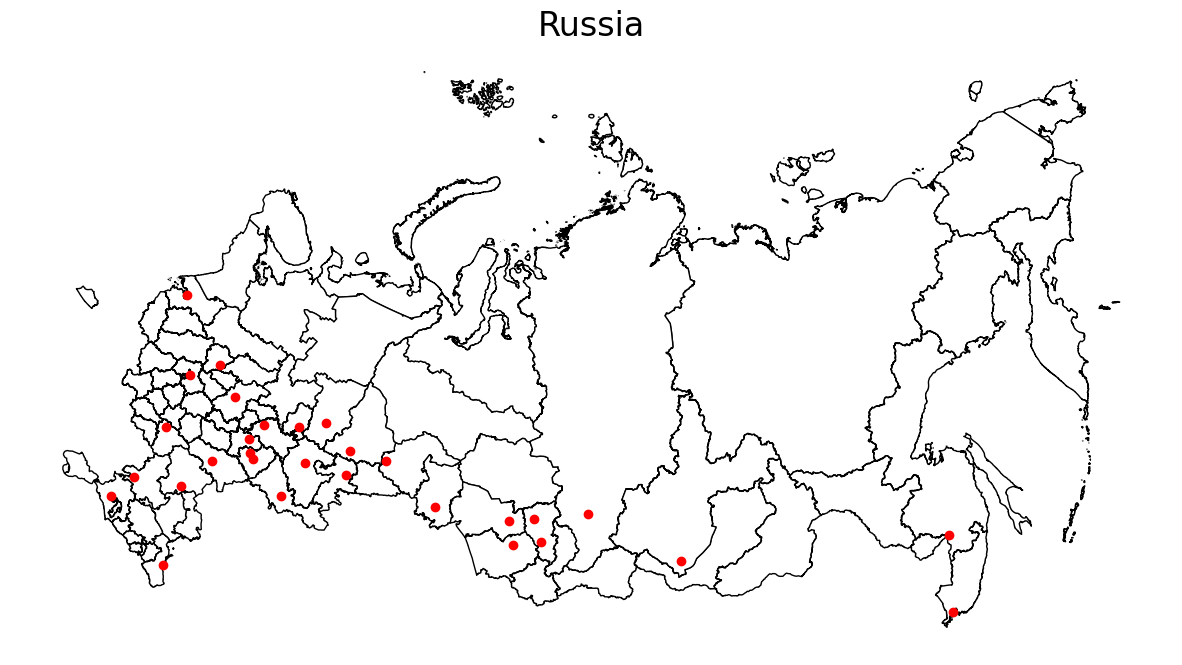

In [7]:
fig, gax = plt.subplots(figsize=(15,20))

# By only plotting rows in which the continent is 'South America' we only plot SA.
gdf.plot(ax=gax, edgecolor='black',color='white')
gax.scatter(city_30["x"], city_30["y"], marker='o', color='red')
# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.set_title("Russia", fontsize=24)
gax.axis("off")
plt.show()

## Travelling salesman via Simulated annealing

The task is to solve a travelling salesman problem, i.e. find the shortest path which connects all the cities, via simulated annealing approach. 

Considering given task, annealing is formulated as follows:

1. Randomly set initial path x0.
2. Set initial temperature T. 
3. Repeat following until T > 1e-3:
   1. Generate new proposal by swapping two positions in the path.
   2. Compute energy, associated with new configuration:
        $$p^*_{sales}(path_i) = \exp \left(\frac{-dist(path)}{T_i}\right)$$
   3. Compare it with metric on previous iteration: 
        $$\alpha = \frac{p^*_{sales}(path_i)}{p^*_{sales}(path_{i-1})}$$
   4. Generate $u \sim U(0,1)$. If $u \leq \alpha$, accept the new path, otherwise propagate the old one.
   5. Reduce temperature T as:
          $$T_{i+1} = \sigma T_i,$$
     where $\sigma \in (0, 1)$.

First, let's introduce a distance metric, which computes distance between points based on longitute and latitude:

In [8]:
def dist(path: list[int], df: pd.DataFrame) -> float:
    total_dist = distance(
            tuple(df.loc[path[0], ["geo_lat", "geo_lon"]]),
            tuple(df.loc[path[-1], ["geo_lat", "geo_lon"]])
        ).kilometers
    for i in range(len(path)-1):
        total_dist += distance(
            tuple(df.loc[path[i], ["geo_lat", "geo_lon"]]),
            tuple(df.loc[path[i+1], ["geo_lat", "geo_lon"]])
        ).kilometers
    return total_dist

def energy(path: list[int], df: pd.DataFrame, T: float) -> float:
    total_dist = dist(path, df)
    return np.exp(-total_dist / T)

In [9]:
def simulated_annealing(T_0: float = 50000, sigma: float = 0.9, T_update_sleep: int = 10) -> tuple[list[int], np.ndarray, np.ndarray]:
    optimal_path = np.random.permutation(30)
    T = T_0 #value around the randomly generated distance
    tick = 0
    optimal_energy = energy(optimal_path, city_30, T)

    path_history: list[np.ndarray] = [optimal_path]
    T_history: list[float] = [T]

    while T > 1e-3:
        new_path = optimal_path.copy()
        rnd_idx1, rnd_idx2 = 0, 0 
        while rnd_idx1 == rnd_idx2:
            rnd_idx1, rnd_idx2 = np.random.randint(30), np.random.randint(30)
        new_path[rnd_idx1], new_path[rnd_idx2] = new_path[rnd_idx2], new_path[rnd_idx1]

        new_energy = energy(new_path, city_30, T)
        alpha = new_energy / optimal_energy

        if np.random.uniform(0, 1) < alpha:
            optimal_path = new_path
            optimal_energy = new_energy

        if tick % T_update_sleep == 0:
            T = sigma * T
            path_history.append(optimal_path)
            T_history.append(T)

        tick += 1

    return optimal_path, np.array(path_history), np.array(T_history)

In [10]:
opt_path, path_history, T_history = simulated_annealing(sigma=0.95)
distance_history = np.array([dist(path_i, city_30) for path_i in path_history])
print(f"Path found with optimal distance: {dist(opt_path, city_30)}")

Path found with optimal distance: 32727.85815948577


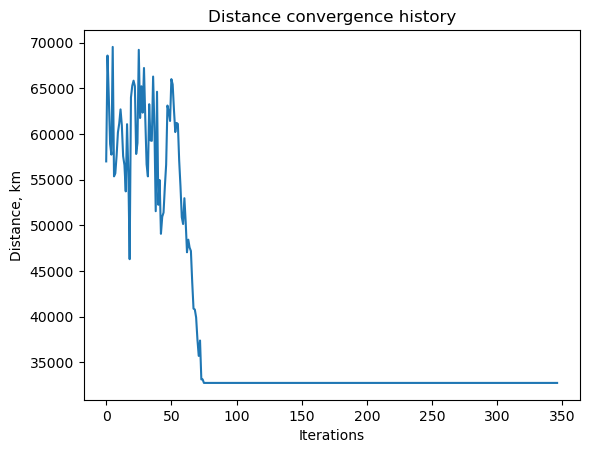

In [11]:
plt.title("Distance convergence history")
plt.xlabel("Iterations")
plt.ylabel("Distance, km")
plt.plot(distance_history)
plt.show()

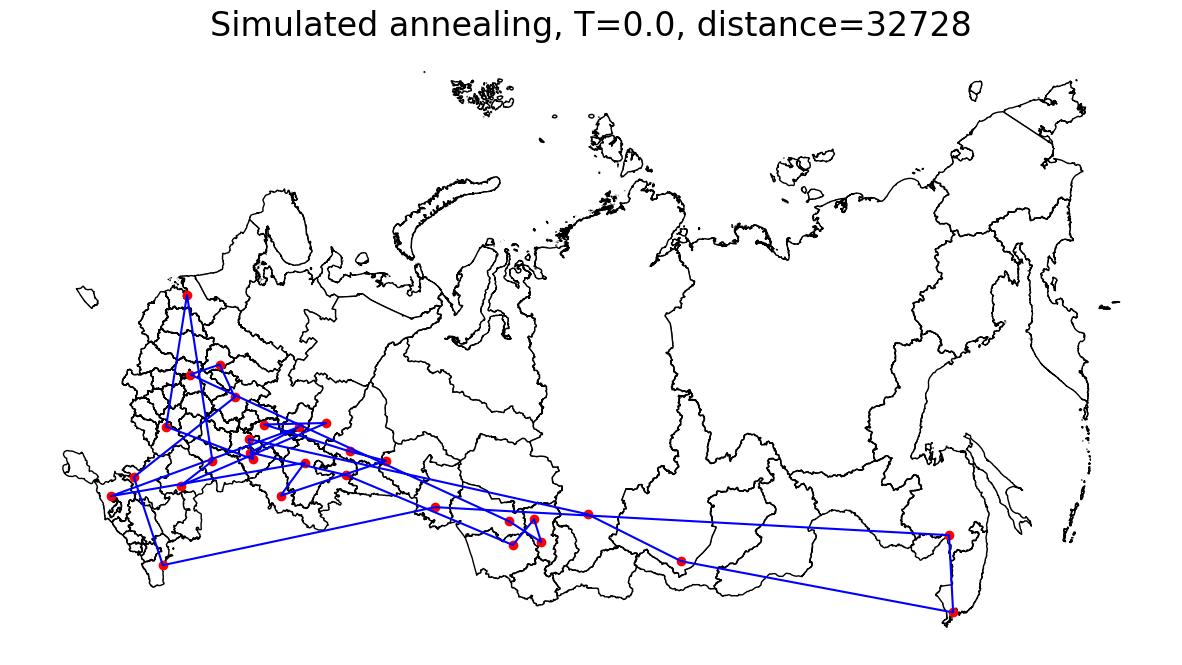

In [12]:
fig, gax = plt.subplots(figsize=(15,20))

# By only plotting rows in which the continent is 'South America' we only plot SA.
gdf.plot(ax=gax, edgecolor='black',color='white')
gax.scatter(city_30["x"], city_30["y"], marker='o', color='red')
# By the way, if you haven't read the book 'longitude' by Dava Sobel, you should...
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.set_title(f"Simulated annealing, T={T_history[0]}, distance={distance_history[0]}", fontsize=24)
gax.axis("off")

path_line, = gax.plot(city_30.loc[path_history[0], "x"].to_numpy(), city_30.loc[path_history[1], "y"].to_numpy(), 'b-')

def update(tick):
    gax.set_title(f"Simulated annealing, T={T_history[tick]:0.1f}, distance={distance_history[tick]:0.0f}", fontsize=24)
    xdata = city_30.loc[path_history[tick], "x"].to_numpy()
    ydata = city_30.loc[path_history[tick], "y"].to_numpy()
    path_line.set_xdata(np.concatenate([xdata, xdata[0:1]]))
    path_line.set_ydata(np.concatenate([ydata, ydata[0:1]]))
    
    return path_line, 

ani = anim.FuncAnimation(
    fig, update, interval=50, blit=True, frames=len(path_history))
ani.save(filename="annealing.gif", writer="pillow");

![](annealing.gif)

Great, the annealing is working. Now, let't test different annealing rates $\sigma:$

In [13]:
sigmas = [0.5, 0.6, 0.7, 0.8, 0.9, 0.99]

optimal_paths = []
optimal_distances = []
path_histories = []
T_histories = []

for sigma in sigmas:
    opt_path, path_history, T_history = simulated_annealing(sigma=sigma)
    distance_history = np.array([dist(path_i, city_30) for path_i in path_history])

    optimal_paths.append(opt_path)
    optimal_distances.append(distance_history)
    path_histories.append(path_history)
    T_histories.append(T_history)

    print(f"For sigma={sigma}, optimal distance is: {dist(opt_path, city_30)}")

For sigma=0.5, optimal distance is: 58714.023438187796
For sigma=0.6, optimal distance is: 59606.45221024617
For sigma=0.7, optimal distance is: 63224.38834862755
For sigma=0.8, optimal distance is: 51854.076577437285
For sigma=0.9, optimal distance is: 45260.74085257859
For sigma=0.99, optimal distance is: 24041.27932532948


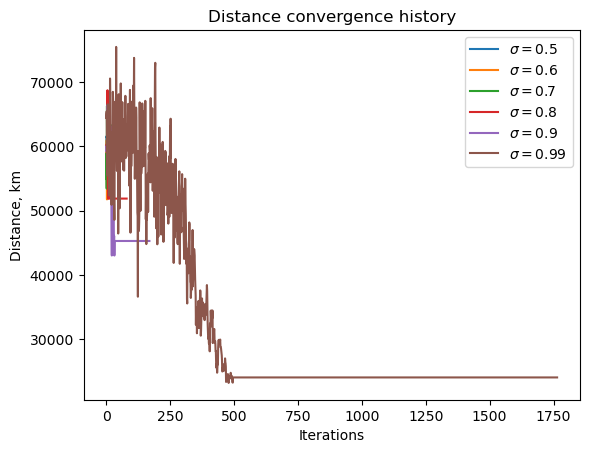

In [14]:
plt.title("Distance convergence history")
plt.xlabel("Iterations")
plt.ylabel("Distance, km")
for i, opt_dists in enumerate(optimal_distances):
    plt.plot(opt_dists, label=f"$\\sigma = {sigmas[i]}$")
plt.legend()
plt.show()

As you could see, the slower is a cooling, the better achieved results are. Let's finalize this work by visualizing the best path history, for $\sigma=0.99$

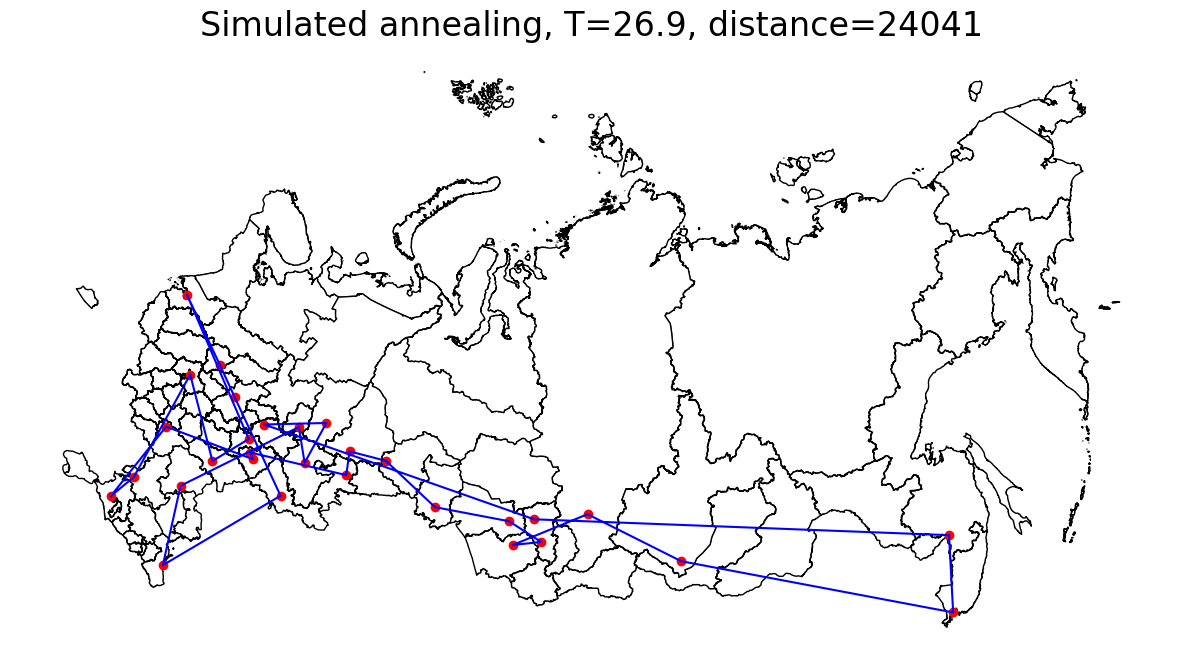

In [15]:
N_iterations = 750


path_history = path_histories[-1][:N_iterations]
T_history = T_histories[-1][:N_iterations]
distance_history = optimal_distances[-1][:N_iterations]

fig, gax = plt.subplots(figsize=(15,20))

gdf.plot(ax=gax, edgecolor='black',color='white')
gax.scatter(city_30["x"], city_30["y"], marker='o', color='red')
gax.set_xlabel('longitude')
gax.set_ylabel('latitude')

gax.set_title(f"Simulated annealing, T={T_history[0]}, distance={distance_history[0]}", fontsize=24)
gax.axis("off")

path_line, = gax.plot(city_30.loc[path_history[0], "x"].to_numpy(), city_30.loc[path_history[1], "y"].to_numpy(), 'b-')

def update(tick):
    gax.set_title(f"Simulated annealing, T={T_history[tick]:0.1f}, distance={distance_history[tick]:0.0f}", fontsize=24)
    xdata = city_30.loc[path_history[tick], "x"].to_numpy()
    ydata = city_30.loc[path_history[tick], "y"].to_numpy()
    path_line.set_xdata(np.concatenate([xdata, xdata[0:1]]))
    path_line.set_ydata(np.concatenate([ydata, ydata[0:1]]))
    
    return path_line, 

ani = anim.FuncAnimation(
    fig, update, interval=50, blit=True, frames=len(path_history))
ani.save(filename="best_annealing.gif", writer="pillow");

![](best_annealing.gif)

## Conclusion

As summary, the simulated annealing successfully found a solution to the problem (although we could not guarantee that it is correct). 

The annealing coefficient defined how long cooling would be, and therefore how long the annealing process would take. Experiments showed that the longer annealing process lasts, the lower distance is found.